In [ ]:
# @title Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import arviz as az  # https://python.arviz.org/en/stable/user_guide/plotting_with_matplotlib.html
import pymc as pm   # https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html

!wget https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter1_Introduction/data/txtdata.csv -q
!wget -O Howell1.csv https://raw.githubusercontent.com/deep-learning-indaba/indaba-pracs-2023/main/data/Howell1.csv -q

rng = np.random.default_rng(seed=1234)

In [ ]:
# @title Helper Functions
from itertools import islice
from collections import namedtuple

### helper functions

VarStats = namedtuple('VarStats', 'mean sd hdi_min, hdi_max')

def get_stats(idata, name, hdi_prob=0.9):
  return VarStats(*az.summary(idata, hdi_prob=hdi_prob, kind="stats").loc[name])

def show_hist(samples, title, var_name, xlim=None, figsize=(10,6), bins=40):
  fig, ax = plt.subplots(figsize=figsize)
  ax.set_title(title, fontsize=14)
  ax.set_xlabel(var_name, fontsize=12)
  if xlim is None:
    xlim = (min(min(sample) for sample in samples)*0.99,
            max(max(sample) for sample in samples)*1.01)
  ax.set_xlim(*xlim)
  for sample in samples:
    ax.hist(sample, bins=bins, density=True);

def draw_lines(alpha, beta, X, Y, n_lines=50, draw_mean=True):
  fig, ax = plt.subplots(figsize=(6,4))
  ax.scatter(X, Y, zorder=2)
  xmin, xmax = ax.get_xbound()
  for intercept, slope in islice(zip(alpha, beta), n_lines):
    ax.axline((xmin, (xmin*slope)+intercept),
              (xmax, (xmax*slope)+intercept), color='#dddddd', zorder=1)
  # mean line
  if draw_mean:
    intercept_mean, slope_mean = np.mean(alpha), np.mean(beta)
    ax.axline((xmin, (xmin*slope_mean)+intercept_mean),
              (xmax, (xmax*slope_mean)+intercept_mean), color='r', zorder=3)

---

## Introduction

> *There is no such thing as luck; there is only adequate or inadequate preparation to cope with a statistical universe* -- Robert A. Heinlein

In Computer Science, for a given problem, we write an appropriate function $f$ with certain parameters $x$ to output values $y$ wrt the given parameter values. So $y$ is computed by $y = f(x)$.

Probability has a similar workflow, where the function, or algorithm, is replaced by a probabilistic model. For example, the probability of $k$ successes in a sequence of $n$ independent experiments, with a success probability of $\theta$ is given by

$$Pr(k|n,\theta) = {n \choose k}\theta^k(1-\theta)^{n-k}$$

where the probability for $k$ successes is the output, and $k,n,\theta$ the parameters.

We can get answers for probabilitic problems either by analytic solutions,

In [ ]:
from math import comb
import numpy.random as npr

def prob_binomial(k, n, θ):
  """ analytic solution """
  return comb(n, k) * θ**k * (1-θ)**(n-k)

print(prob_binomial(3, 10, θ=0.5))

0.1171875


or by simulation,

In [ ]:
def prob_binomial_sim(k, n, θ, n_iters=100_000):
  """ solution by simulation """
  experiences = npr.binomial(n, p=θ, size=(n_iters,))
  return sum(experiences==k) / n_iters

print(prob_binomial_sim(3, 10, θ=0.5))

0.11743


In Statistics, again for a given problem, we have the opposite informational flow.

It is the output (the observations) $y$ that is given, not its parameters $x$. The (Bayesian) Statistician must create an appropriate probabilistic model of $p(x,y)$ that can be fitted to provide conditional distributions $p(x|y)$ over the unknown parameters given the known observations.

<br><center><img src='https://raw.githubusercontent.com/jpneto/topicsInPython/main/imgs/probabilistic_programming.tensorflow.png' width=600px><br>(c) TensorFlow website</center>

The goal of probabilistic programming is to facilitate the problem of statistical modelling.

In the context of probabilistic programming these models are specified by a set of random variables and their distributions which then can be automatically executed. These models can be described in a declarative fashion (by softwares like BUGS or JAGS), in an imperative fashion (like in Python's library `emcee`) or in a mix of both (like Stan or `PyMC`).

## The Probabilistic Programming Approach

For a certain problem, a probabilistic model $\mathcal{M}$ has a set of parameters $\theta$, each a random variable defined by a distribution.

The available data $\mathcal{D}$ is used to fit the model and compute the conditional distribution $p(\theta~|~\mathcal{D})$ from which we can analyse, infer conclusions and make decisions.

Why? Because the result shows how the parameters' distribution shape must be after considering the available data, assuming the model we decided to use.

The rules of probability tell us how to compute this distribution:

$$p(\theta~|~\mathcal{D}) = \frac{p(\mathcal{D},\theta)}{p(\mathcal{D})} = \frac{p(\mathcal{D}~|~\theta)~p(\theta)}{p(\mathcal{D})}$$

where $p(\mathcal{D}|\theta)$ is called the **likelihood**, $p(\theta)$ the parameters' **prior**, and $p(\theta~|~\mathcal{D})$ the parameter's **posterior**.

Since $p(\mathcal{D})$, denoted the **evidence**, is a constant, we can simplify the expression,

$$p(\theta~|~\mathcal{D}) \propto p(\mathcal{D}~|~\theta)~p(\theta)$$

For numerical reasons it is preferable to work with log values,

$$\underbrace{\log p(\theta~|~\mathcal{D})}_{\text{log posterior}} \propto \underbrace{\log p(\mathcal{D}~|~\theta)}_{\text{log likelihood}} + \underbrace{\log p(\theta)}_{\text{log prior}}$$

> since we didn't consider $p(\mathcal{D})$, $\log p(\theta~|~\mathcal{D})$ is better named the unnormalised log-posterior.

This mathematical reasoning is exactly the same for all models. The model variables are the set of observed values, and the set of parameters.

From the perspective of the model, the observations and the parameters are of the same nature, they are all random variables. The only thing that separates them is that observations are **observed variables** and the parameters are **unobserved variables**.

What the model requires from the programmer is to specify what are the distributions these random variables follow, and how they related to each other.

The results we obtain for the posterior distribution of $\theta$ are not only condicioned to the data $\mathcal{D}$ but also to the model $\mathcal{M}$ we choose (there is not one true model). So, even if implicitly, the relation is,

$$p(\theta~|~\mathcal{D}, \mathcal{M}) \propto p(\mathcal{D}~|~\theta, \mathcal{M})~p(\theta | \mathcal{M})$$

> For brevity and to keep the notation as simple as possible, we will usually omit the model reference.

In the perspective of probabilistic programming, once the probabilistic model is defined, the inference part can be automated. We just input the data, call the appropriate functions, and the posterior distributions for the unknown variables are computed. The user does not need to know how the inference part is computed, which means doing statistical inference on a higher level of abstraction.

### Example: Inferring the rate of a binary process

Consider this problem: Given a binary process with $k$ observed successes from a fixed number of $n$ trials, what is the success rate $\theta$?

This is the typical problem modelled as a coin toss or taking a ball from a urn (with replacement).

In our example, we need to choose appropriate distributions to define our random variables:

+ We pick the binomial distribution for $k$ since this is a classical distribution for counting discrete outcomes.

+ Variable $\theta$ represents a probability, it must be associated with a distribution with domain $[0,1]$. Again, the classical choice is the Beta distribution. Since we don't have any preferences of prior values of $\theta$, we will select $\text{Beta}(1,1)$ which assigns the same probability density for all values in $[0,1]$.

These associations can be described with the standard notation, $x \sim d$, i.e., random variable $x$ follows distribution $d$.

The chosen model can be stated as,

$$k \sim \text{Binomial}(n, \theta)$$

$$\theta \sim \text{Beta}(1,1)$$

That's it. _This is the entire probabilistic model for the problem!_

Given that

$$\log p(\theta~|~k,n) \propto \log p(k~|~\theta,n)+ \log p(\theta)$$

<!-- p(theta|n) = p(theta) since they are indepedent -->

we would wish to find a $\theta$ that maximizes the product of the log-likelihood and the log-prior, given the initial data.

This is where the inference process begins.

Let's first consider this as an optimization problem.

The next couple of functions compute the unnormalized log posterior $\log p(\theta~|~k,n)$,

In [ ]:
import jax.scipy.stats as ss
import jax.numpy as np

def binom_logpmf(theta, k, n):
  """ Jax does not have a binomial pmf, so we make one """
  if theta <= 0 or theta >=1: # no support outside ]0,1[
    return -np.inf
  return k*np.log(theta) + (n-k)*np.log(1-theta)

def log_posterior(theta, k, n):
  """ log-posterior for our binomial model """
  log_lik         = binom_logpmf(theta[0], k, n)
  log_prior_theta = ss.beta.logpdf(theta[0], 1, 1)
  return log_lik + log_prior_theta

Let's consider data $\mathcal{D}=\{k:6, n:9\}$.

Here is how we optimize the previous log posterior function:

In [ ]:
from scipy.optimize import minimize
from jax import grad # provides a function's gradient (!)

f = lambda theta: -log_posterior(theta, k=6, n=9)

opt = minimize(f, np.array([.5]), method="BFGS", jac=grad(f))
opt.x[0]

0.6666997450099396

This result matches the value of $\theta$ found by [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation),

$$\hat{\theta}_{MLE} = {\arg \max}_{\theta} ~ p(\mathcal{D} \mid \theta)$$

which is $\hat{\theta} = k/n = 0.6667$.

Anyway, it seems a lot of complex calculations just to replace the simpler MLE's approach.

Well, yes... for this case.

But probabilistic modelling _scales_!

### Example: Infering a Normal Distribution

Consider we have some data $y$:

In [ ]:
# extract random normal values
import numpy.random as npr
npr.seed(101)

mu, sigma, n = 10, 5, 250
y = npr.normal(loc=mu, scale=sigma, size=n)

We want to write a probabilistic model able to generate $y$ values.

Assume we don't know the mean and variance values that produced $y$, but we have some information that the mean is not that far from zero, and that the variance is finite. From this information, we decide to use a normal distribution to model $y$.

Thus $\mu, \sigma$ will be the parameters for this normal, where we will try to code our prior knowledge:

+ For the mean $\mu$ we don't know if it is positive or negative, only that is not that large. So we will associate a normal distribution with a large standard deviation, say $\mu \sim \mathcal{N}(0, 10)$

+ For the standard deviation, we know $\sigma$ is finite, and that it is positive (there are not zero or negative variances), so we choose a typical [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) to model positive values, $\sigma \sim \text{Gamma}(2,0.1)$

So, this is the probability model for $y$,

$$y_i \sim \mathcal{N}(\mu, \sigma^2)$$

$$\mu \sim \mathcal{N}(0, 10)$$

$$\sigma \sim \text{Gamma}(2,0.1)$$

Given data $y$ we wish to infer the parameter's posterior distributions $p(\mu|y)$ and $p(\sigma|y)$.

$$p(\mu, \sigma~|~\mathcal{D}) \propto p(\mathcal{D}~|~\mu, \sigma)~p(\mu, \sigma) = p(\mathcal{D}~|~\mu, \sigma)~\underbrace{p(\mu)~p(\sigma)}_{\mu~\perp~\sigma}$$

The next function computes the unnormalized log posterior, given values for parameters $\theta = \{\mu,\sigma\}$,

In [ ]:
def log_posterior(theta, y):
  μ, σ = theta
  log_lik         = np.sum( ss.norm.logpdf(y, μ, σ) )
  log_prior_mu    = ss.norm.logpdf(μ, 0, 10)
  log_prior_sigma = ss.gamma.logpdf(σ, 2, 0.1)
  return log_lik + log_prior_mu + log_prior_sigma

We can apply `minimize`, together with `grad`, to maximize this posterior expression wrt $\theta$.

Here's the optimization step:

In [ ]:
f = lambda theta : -log_posterior( theta, y )

res = minimize(f, np.array([4,4]), method="BFGS", jac=grad(f))
res.x

array([10.24733918,  5.11917687])

And it's done!

Here are the results against the true parameters,

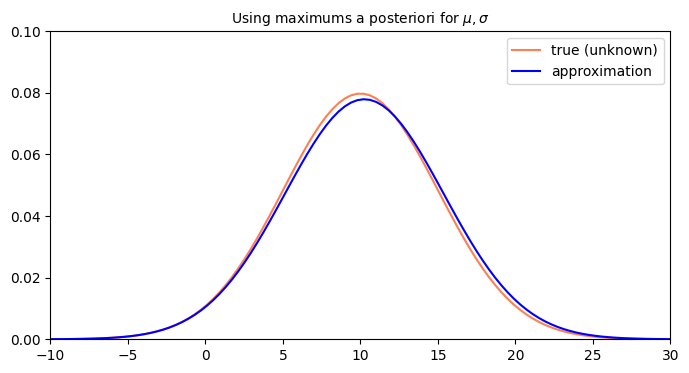

In [ ]:
#@title
import matplotlib.pyplot as plt

plt.subplots(figsize=(8,4))

x_min, x_max = -10,30
x = np.linspace(x_min, x_max, 100)
y_true = ss.norm.pdf(x,mu,sigma)
plt.plot(x,y_true, color='coral')

y_pred = ss.norm.pdf(x,res.x[0],res.x[1])
plt.plot(x,y_pred, color='blue')

plt.xlim(x_min,x_max)
plt.ylim(0,0.1)
plt.title('Using maximums a posteriori for $\mu,\sigma$',fontsize=10)
plt.legend(['true (unknown)', 'approximation'])
plt.show()

## Tools for Probabilistic Programming

The previous optimizations only compute the parameter values that maximize the likelihood of data given the parameters.

But the probabilistic model approach shows how to compute the entire posterior distribution (not just the maximum, or mode). The posterior has much more information that can be useful to analyse the results, and produce better decisions.

Herein, we are going to use Python library `pyMC` that retrieves the full posterior distribution.

`pyMC` introduces a new class representing probabilistic models. And for any given model, we can add new variables with their respective distributions.

Let's create a model for the rate of a binary process shown above:

In [ ]:
def beta_binomial_model(k, n): # model factory
  model = pm.Model()
  with model:
    theta = pm.Beta("theta", alpha=1, beta=1)      # unobserved variable
    k = pm.Binomial("k", n=n, p=theta, observed=k) # observed variable (fix k's value)
  return model

After the model is defined, we can fit it and then sample from the posterior:

In [ ]:
model = beta_binomial_model(k=6, n=9) # create a model based on some given data

with model:
  idata = pm.sample(draws=5000)    # fit model and draw n posterior samples

Let's get some basic statistics from the posterior:

In [ ]:
get_stats(idata, 'theta', hdi_prob=0.95) # get a summary for p(theta|data)

VarStats(mean=0.638, sd=0.139, hdi_min=0.362, hdi_max=0.894)

Sampling a model produces samples for all unobserved variables (here we just have one, $\theta$). These samples can be used as empirical distributions that approach the parameters' posterior distributions (for which we don't have analytical solutions).

For example, let's compare the prior $p(\theta)$ and posterior of $p(\theta|\mathcal{D})$ given data $\mathcal{D}=\{k:6, n:9\}$:

In [ ]:
prior_theta     = pm.draw(model.theta, draws=20_000)             # draw from prior
posterior_theta = np.array(idata.posterior['theta']).reshape(-1) # get all chains

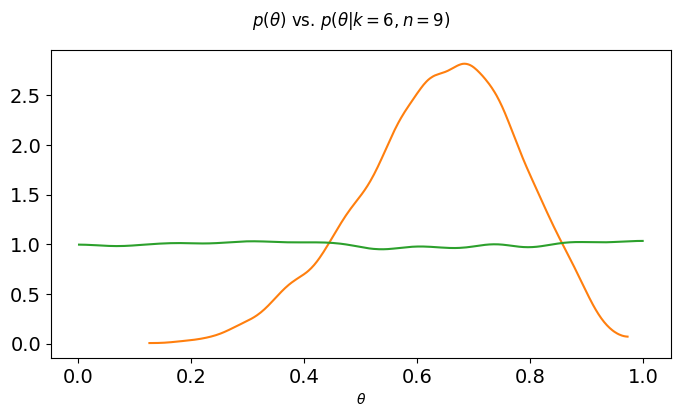

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
fig.suptitle(r'$p(\theta)$ vs. $p(\theta | k=6,n=9)$')
ax.set_xlabel(r'$\theta$')

az.plot_dist(posterior_theta, color="C1")
az.plot_dist(prior_theta, color="C2");

What if, instead of $k=6,n=9$, we had $k=60,n=90$?

The probabilistic model is the same, we just need to input the new data values:

In [ ]:
model = beta_binomial_model(60, 90)

with model:
  idata2 = pm.sample(draws=5000)   # draw n posterior samples

Let's compare the prior with the posteriors for the two sets of data:

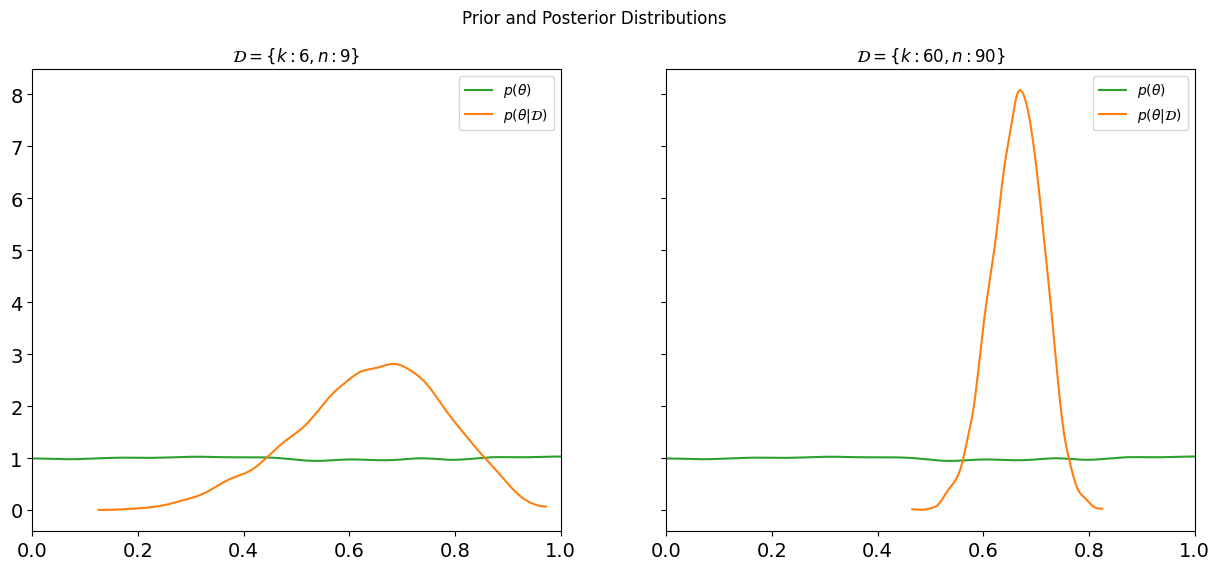

In [ ]:
#@title
fig, ax = plt.subplots(1, 2, figsize=(15,6), sharey=True)
fig.suptitle("Prior and Posterior Distributions")

ax[0].set_title(r"$\mathcal{D}=\{k:6,n:9\}$")
ax[0].set_xlim(0, 1)
az.plot_dist(prior_theta, color="C2", label=r"$p(\theta)$", ax=ax[0])
az.plot_dist(idata.posterior['theta'], color="C1", label=r"$p(\theta|\mathcal{D})$", ax=ax[0])

ax[1].set_title(r"$\mathcal{D}=\{k:60,n:90\}$")
ax[1].set_xlim(0, 1)
az.plot_dist(prior_theta, color="C2", label=r"$p(\theta)$", ax=ax[1])
az.plot_dist(idata2.posterior['theta'], color="C1", label=r"$p(\theta|\mathcal{D})$", ax=ax[1]);

This second result expresses less uncertainty (the conditional distribution is thinner). This makes sense. If we only perform 9 trials, it is to be expected that we will know less about the system under study, than if we perform 90 trials.

Notice that the MLE estimation would be the same for both problems, $\hat{\theta} = 6/9 = 60/90$, since:

+ It does take into account the size of data we have

+ It provides no information about its uncertainty

The probabilistic model gives more useful information.

### Comparisation with standard statistical methods

To compute the uncertainty interval using standard classical methods -- denoted confidence interval -- we can use standard Python libraries:

In [ ]:
from statsmodels.stats.proportion import proportion_confint

proportion_confint(6, 9, alpha=0.05, method='wilson')

(0.3542021355803961, 0.879416181613089)

But this function is a black box. It provides [five different methods](https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_confint.html) to compute the confidence interval. What method should we use? Each produces different results. Besides that, the values from this confidence interval cannot be interpreted as probabilities. Instead:

> The confidence level represents the long-run proportion of confidence intervals that theoretically contain the true value of the parameter. For example, out of all intervals computed at the 95% level, 95% of them should contain the parameter's true value. [[wikipedia](https://en.wikipedia.org/wiki/Confidence_interval)]

<font size=+1>😵</font>

The posterior uncertainty interval -- denoted credible interval -- allows for a more intuitive interpretation: there is a 95% probability that the parameter lies within that interval.

Also, usually the standard statistical methods express less uncertainty (ie, they are smaller) than these probabilistic results. This might seem as an advantage but [it is not](https://stats.stackexchange.com/questions/2272).

## Use Case: Linear Regression

Linear regression is one of the most used statistical models. This model assumes a linear relation between input $x$ and output $y$.

A probabilistic model for linear regression can be defined like this,

$$
\begin{aligned}
 Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta X\\
\\
\alpha &\sim \mathcal{N}(0, 10^2) \\
\beta &\sim \mathcal{N}(0, 10^2) \\
\sigma &\sim \lvert\mathcal{N}(0, 1){\rvert}
\end{aligned}
$$

We wish to fit the parameters $\mu, \sigma$ for the normal distribution that (as we decided) models the output.

The distribution's mean is where the linear relation occurs. Parameter $\mu$ is to be found deterministically by two other parameters $\alpha, \beta$ that specify the line intercept and slope. Parameter $\sigma$ models the noise associated with measuring input $x$.

Let's make some data to test this model:

In [ ]:
α, β, σ = 1, 2, 2.5   # true (unknown) parameter values

n = 150
X = 2*npr.randn(n)
Y = α + β * X + σ * npr.normal(size=n)

and plot them:

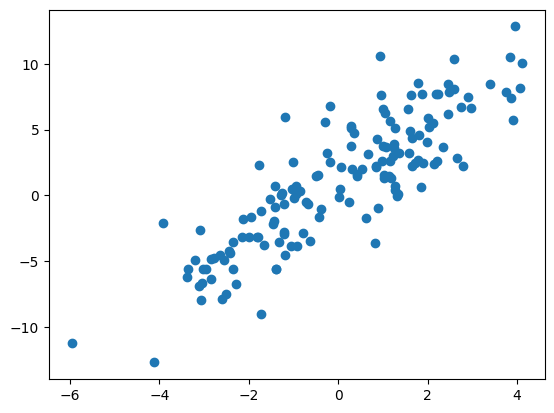

In [ ]:
plt.scatter(X, Y, label='data');

The model for the linear regression written in `pyMC`:

In [ ]:
def linear_model(X, Y):
  with pm.Model() as model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta  = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)
    # Expected value of outcome
    mu = alpha + beta * X
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)
  return model

Let's define the model for the given data:

In [ ]:
model_l = linear_model(X, Y)

With `pyMC` it is possible to visualize the variable relations (the observed values are in gray):

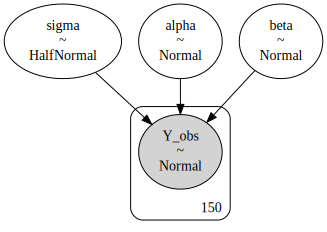

In [ ]:
pm.model_to_graphviz(model_l)

In [ ]:
with model_l:
  idata3 = pm.sample(draws=5000)   # draw n posterior samples

Let's plot the posteriors (the vertical lines represent the parameters' values we used to create the data):

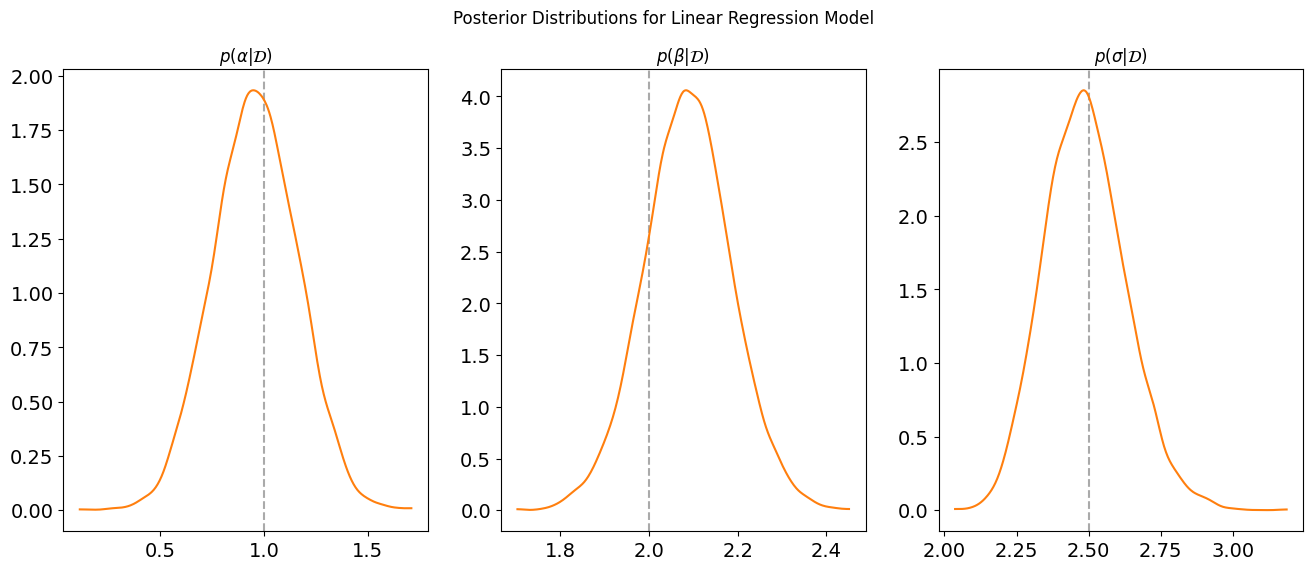

In [ ]:
#@title
fig, ax = plt.subplots(1, 3, figsize=(16,6))
fig.suptitle("Posterior Distributions for Linear Regression Model")

ax[0].set_title(r"$p(\alpha | \mathcal{D})$")
ax[0].axvline(x = α, color = '#aaaaaa', linestyle='--')
az.plot_dist(idata3.posterior['alpha'], color="C1", ax=ax[0])

ax[1].set_title(r"$p(\beta | \mathcal{D})$")
ax[1].axvline(x = β, color = '#aaaaaa', linestyle='--')
az.plot_dist(idata3.posterior['beta'], color="C1", ax=ax[1])

ax[2].set_title(r"$p(\sigma | \mathcal{D})$")
ax[2].axvline(x = σ, color = '#aaaaaa', linestyle='--')
az.plot_dist(idata3.posterior['sigma'], color="C1", ax=ax[2]);

## Sampling Models

Probability models are **generative models** since they are able to model the joint probability $p(\text{parameters}, \text{data})$. This implies that generative models are able to generate new samples that follow the shape of the data used to initially fit them.

This linear regression model is thus able to generate regression lines, and because of that, is able to generate as many new data points $(x,y)$ as needed.

The next plot shows some lines sampled from the model (in gray) and the line produced by the sample means (in red):

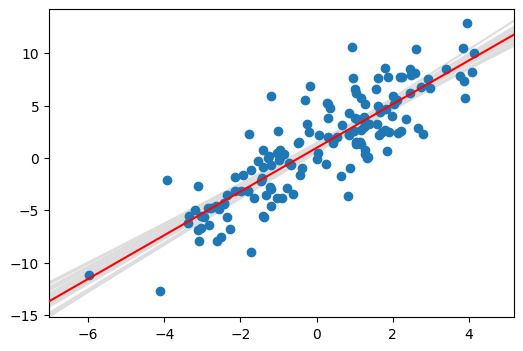

In [ ]:
#@title
post_alpha = np.array(idata3.posterior['alpha']).reshape(-1)
post_beta  = np.array(idata3.posterior['beta']).reshape(-1)
post_sigma = np.array(idata3.posterior['sigma']).reshape(-1)

draw_lines(post_alpha, post_beta, X, Y)

The $n\%$ highest density interval (HDI) contains $n\%$ of all points such that every point inside the interval have a higher probability density than all points outside the interval.

The next plot shows the $95\%$ HDI the model produces for values of $y$ given each $x$ value, and compare them with the real data:

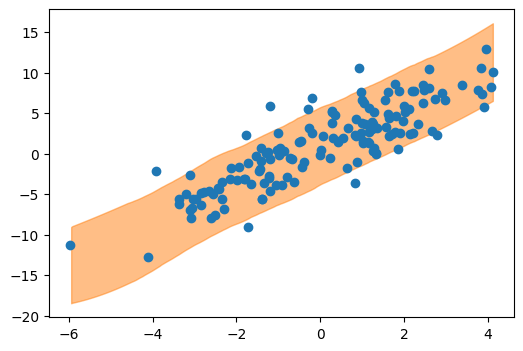

In [ ]:
# @title
fig, ax = plt.subplots(figsize=(6,4))
hdi_prob = 0.95

Y_gen = intercept_mean + slope_mean * X
Y_hdi = npr.normal(Y_gen, np.mean(post_sigma), (2,100,n)) # shape (chain, draw, shape)
az.plot_hdi(X, Y_hdi, hdi_prob=hdi_prob, plot_kwargs={"ls": "-."}, color='C1', smooth=True, ax=ax)
ax.scatter(X, Y);

## Diagnostics

The fit process is based on Markov chains - each new sample depends on the previous -- and might fail due to convergence problems. It is good practice to check if the chains went well.

One diagnostic checks if the chains are similar and seem to explore each parameter space. The left column the empirical distributions for each parameter, and within the same parameter, the different markov chains. The right column shows, for each parameter, the sampled values of its chains.

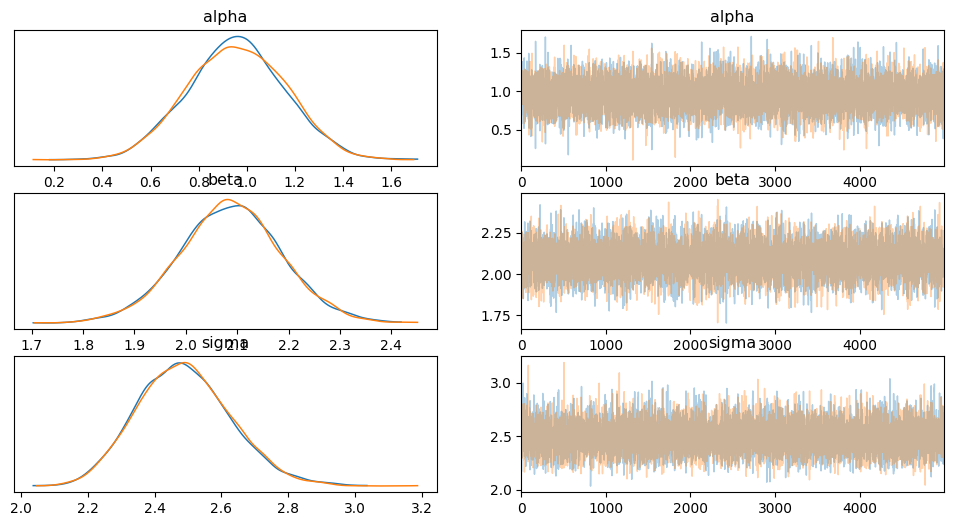

In [ ]:
az.plot_trace(idata3, combined=False, compact=False);

Another diagnostic is to check if the estimation of Effective Sample Size (ESS) is a large number and that convergence diagnostic $\hat{r}$ is near $1$:

In [ ]:
az.summary(idata3, hdi_prob=0.9, round_to=2)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.87,0.43,0.15,1.57,0.0,0.0,14279.88,8106.64,1.0
beta,2.46,0.21,2.13,2.81,0.0,0.0,11774.52,7424.00,1.0
sigma,3.02,0.27,2.57,3.43,0.0,0.0,13952.49,7552.62,1.0


A third diagnostic is the autocorrelation plot among samples in the same chain. These samples, when separated at fixed intervals (the _lag_) are expected to have no correlation, so autocorrelation values shown in the plot should quickly go to $0$:

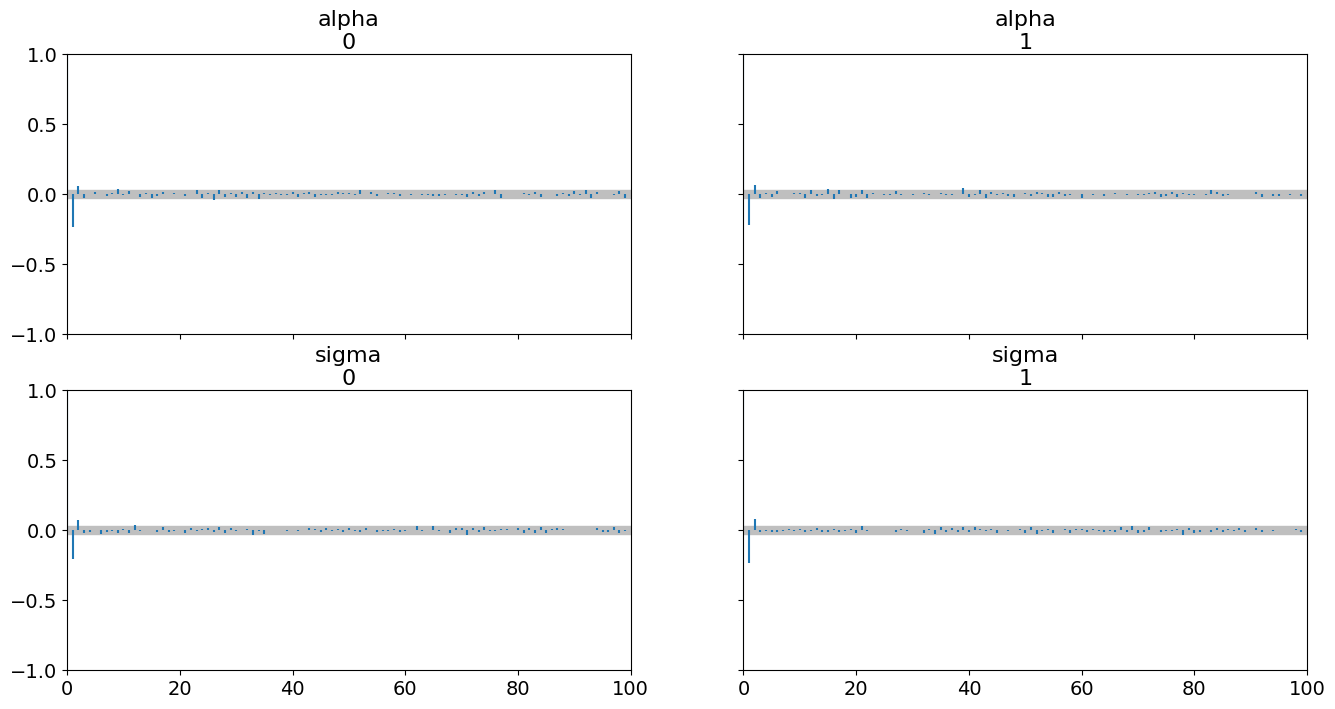

In [ ]:
az.plot_autocorr(idata3, grid=(2,2), figsize=(16,8), var_names=["alpha", "sigma"]);

If these three diagnostics are ok, we can be confident that the sample chains are «healthy», and we may perform inference with them.

## Prior Predictive Check

Choosing prior distributions is not an easy task. The prior distributions are intended to encapsulate problem knowledge we have before analysing the problem. There is always information available (how to study a problem we konw nothing about?).

Usually to select from a well-known set of distributions when modelling our variables. But even when each prior distribution seems reasonable and well grounded, how distributions interact with each other is a very subtle matter.

A good practice is to make a **prior predictive check**, i.e., generate samples from the model _before the fit happens_ in order to check if the prior values are compatible with our initial knowledge.

The next code does a prior predictive check over our linear regression model:

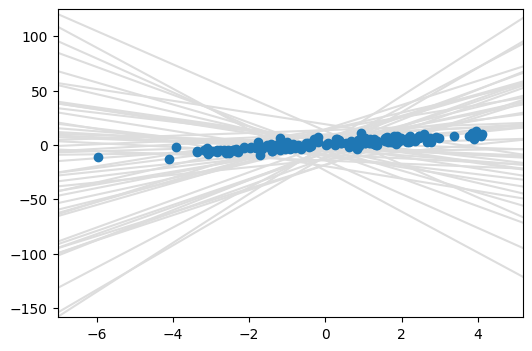

In [ ]:
with model_l:
  # generate samples just from the prior distributions
  prior_pred = pm.sample_prior_predictive(samples=50).prior
  prior_α = np.array(prior_pred['alpha'][0]) # get samples of α and β
  prior_β = np.array(prior_pred['beta'][0])

draw_lines(prior_α, prior_β, X, Y, draw_mean=False)

Remember that the generative model samples regression lines. Is this prior check showing reasonable (prior) linear regressions?

It depends. Suppose we initially knew that the data had a positive correlation, and we just needed to estimate its value. Around half of the prior lines generated have negative slopes. The fitting process is able to correct that, as we saw, but the better our prior distributions model our prior knowledge, the better our posterior results will be.

One way to improve our model would be to change the prior distribution of slope parameter $\beta$ to just generate positive terms, something like:

$$\beta \sim \lvert\mathcal{N}(0, 10^2){\rvert}$$

Or, optionally, select a distribution to gives more probabilistic mass to positive slopes, while still admitting negative values (meta-assuming our prior knowledge assumption might be faulty),

$$\beta \sim \mathcal{N}(10, 10^2)$$

Let's rewrite our linear model using the half normal for $\beta$ and see the prior predictive results:

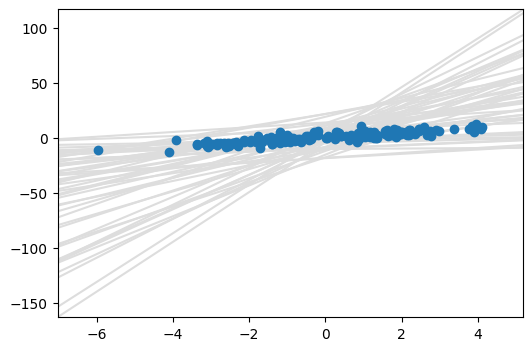

In [ ]:
def linear_model2(X, Y):
  with pm.Model() as model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta  = pm.HalfNormal("beta", sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)
    # Expected value of outcome
    mu = alpha + beta * X
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)
  return model

###

model_l2 = linear_model2(X, Y)

with model_l2:
  # generate samples just from the prior distributions
  prior_pred = pm.sample_prior_predictive(samples=50).prior
  prior_α = np.array(prior_pred['alpha'][0]) # get samples of α and β
  prior_β = np.array(prior_pred['beta'][0])

draw_lines(prior_α, prior_β, X, Y, draw_mean=False)

This is more appropriate assuming the original correlation between $x$ and $y$ should be positive.

## Posterior Predictive Check

The prior predictive is interesting to test if our initial assumptions about the generating process are adequate.

The **posterior predictive check** will validate if the model is adequate at generating values similar to the available data.

Consider this:

+ The probabilistic model implies that there is uncertainty in the data generation process. That is modeled by the likelihood, $p(\mathcal{D}|\theta)$.

+ But for each parameter $\theta_i$, its posterior distribution embodies the uncertainty the model has about $\theta_i$ after seeing the data. That is the posterior distribution $p(\theta_i|\mathcal{D})$ conditional on the data we know.

So there are two intrinsic uncertainties in a probabilistic model.

When we wish to make a prediction, it's fair to consider both uncertainties, not just the first one (typical of frequentist models). Otherwise we will produce overconfident predictions.

Looking at the sampling plot (seen previously),

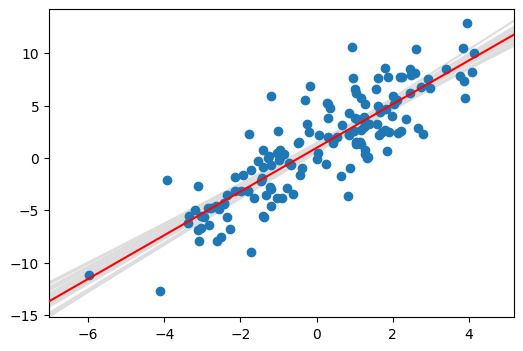

In [ ]:
# @title
draw_lines(post_alpha, post_beta, X, Y)

We must not only focus on the average line, which provides overconfident results (this is the MLE estimate). We should also include the known uncertainty we have on the parameters.

This can be done automatically with the `sample_posterior_predictive` function:

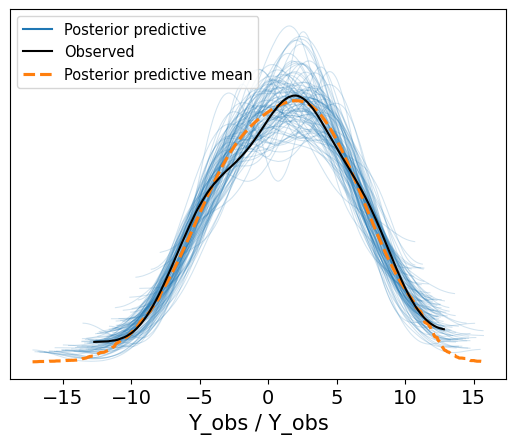

In [ ]:
with model_l:
   pm.sample_posterior_predictive(idata3, extend_inferencedata=True)

az.plot_ppc(idata3, num_pp_samples=100);

This plot shows how well the initial data is predicted by the model. It's no surprise that it is a good prediction (after all, we use this same data to fit the model), but if there was no fit, that would be a warning that something didn't went as expected.

## Predictions

But is the _model adequate at predicting new data_? The fact that it is able to predict old data is good news, but there might be subtle problems with the data (e.g., it might not be representative of the population data) that will strongly degrade the quality of new predictions.

Let's now create new data $X_2,Y_2$ using the same generating process:

In [ ]:
α, β, σ = 1, 2, 2.5

n = 10
X2 = 2*npr.randn(n)
Y2 = α + β * X2 + σ * npr.normal(size=n)

And check what is the model prediction for the new data:

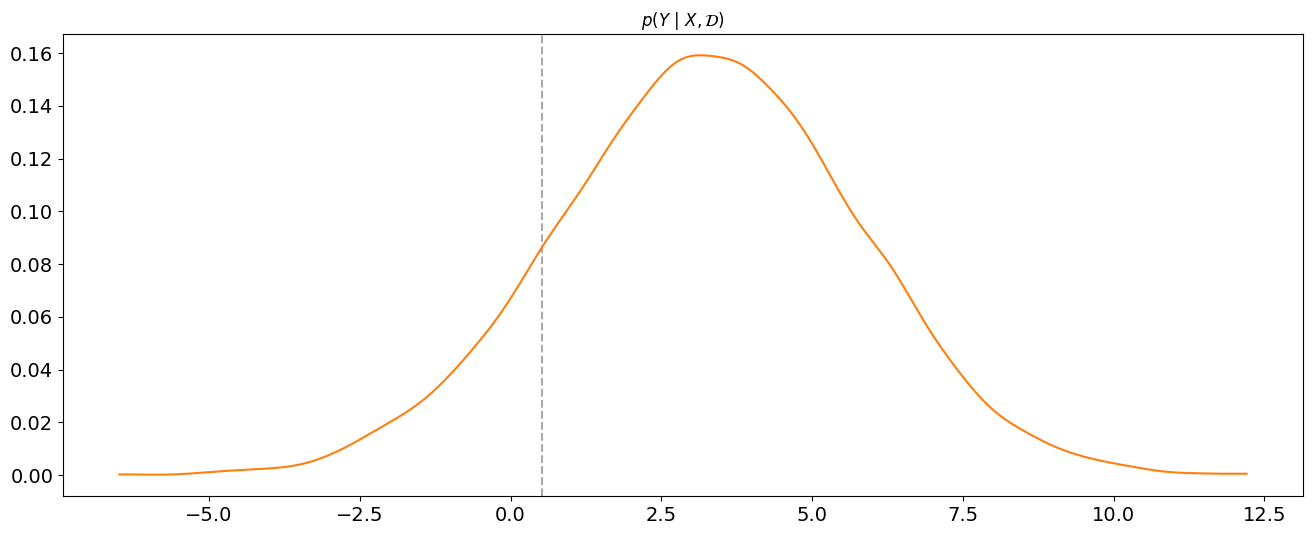

In [ ]:
i = 0  # select one datum

# sample new candidates from the linear model we are using
predict_y = npr.normal(post_alpha + post_beta * X2[i], post_sigma)

fig, ax = plt.subplots(figsize=(16,6))
ax.set_title(r"$p(Y ~ | ~ X, \mathcal{D})$")
ax.axvline(x = Y2[1], color = '#aaaaaa', linestyle='--')
az.plot_dist(predict_y, color="C1");

The histogram is the empirical predictive posterior distribution $p(Y_{\text{new}}|X_{\text{new}}, \mathcal{D})$, where the true value is given by the vertical line.

## Use Case: Text habits

Let's consider the next problem:

> You are given a series of daily text-message counts from a user of your system. The data, plotted over time, appears in the chart below. You are curious to know if the user's text-messaging habits have changed over time, either gradually or suddenly. How can you model this? [[ref](https://nbviewer.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb)]

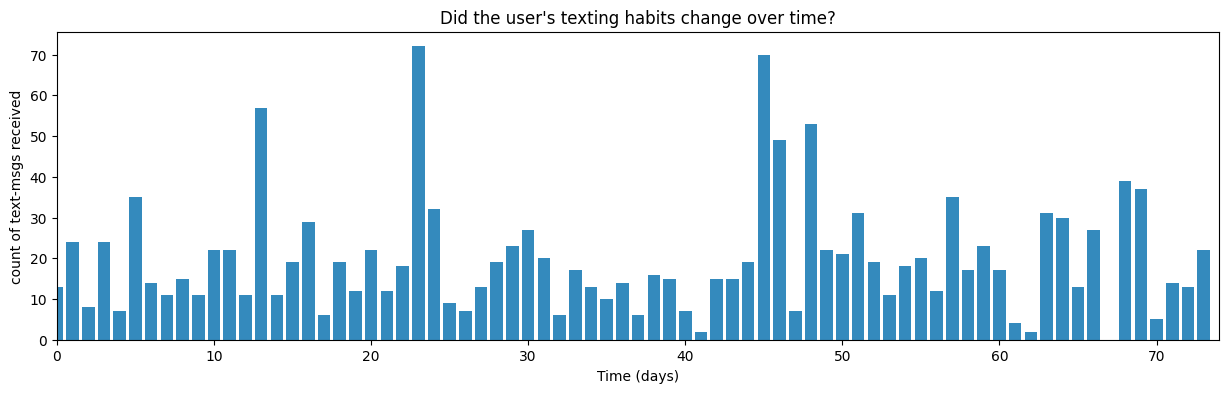

In [ ]:
# @title
count_data = np.loadtxt("txtdata.csv")

fig, ax = plt.subplots(figsize=(15, 4))
ax.set_title("Did the user's texting habits change over time?")
ax.set_xlabel("Time (days)")
ax.set_ylabel("count of text-msgs received")
ax.set_xlim(0, n_count_data)
ax.bar(np.arange(n_count_data), count_data, color="#348ABD");

Modelling count data can be done by using a Poisson. For every day $i$, the number of text messages $C_i$ is a random variable defined as

$$C_i \sim \text{Poisson}(\lambda)$$

To model an eventual change of habits (we assume that, at most, one change of habit might have occurred), parameter $\lambda$ might change at a given time $\tau$,

$$\lambda = \begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}$$

A sudden transition like this is denoted a _switchpoint_. If there were no change, then we should expect $\lambda_1 = \lambda_2$.

We need to consider parameters $\lambda_1, \lambda_2, \tau$:

+ Since the change of habits could have occurred on any given day (and we do not wish introduce bias for any time interval) $\tau$ is a random variable defined by an uniform,

$$\tau \sim \text{DiscreteUniform(1,70) }$$

+ The parameters $\lambda_1, \lambda_2$ are the values of $\lambda$ at a given time, which is the parameter of a Poisson. This means it must be positive. We can use an Exponential to model random variables random variables with only positive outputs

$$\lambda_1 \sim \text{Exp}( \alpha ) \\
\lambda_2 \sim \text{Exp}( \alpha )$$

where $\alpha$ define the shape of exponentials, and is called a _hyper-parameter_ (a parameter of a parameter). We know that a distribution $\text{Exp}( \alpha )$ has mean $1/\alpha$, so we can used the mean of the text counts to provide for its initial value $\alpha = 1/\overline{C}$.

So, the probabilistic model for this problem is,

$$C_i \sim \text{Poisson}(\lambda) \\
\\
\lambda = \begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases} \\
\begin{align} \\
&\lambda_1 \sim \text{Exp}( \alpha ) \\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}\\
\tau \sim \text{DiscreteUniform(1,70) }\\
\alpha = \frac{1}{\overline{C}}$$

In PyMC the model is represented as follows:

In [ ]:
def poisson_model(cout_data):
  n_count_data = len(count_data)
  with pm.Model() as model:
    alpha = 1.0/count_data.mean()
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data-1)

    idx = np.arange(n_count_data)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

    C_i = pm.Poisson("obs", lambda_, observed=count_data)
  return model

Let's fit the model and sample some data from the posterior $p(\lambda_1, \lambda_2, \tau | \mathcal{D})$,

In [ ]:
count_data = np.loadtxt("txtdata.csv")
count_model = poisson_model(count_data)

with count_model:
  idata3 = pm.sample(draws=5000)   # draw n posterior samples

Let's analyse the results:

In [ ]:
az.summary(idata3, hdi_prob=0.9, round_to=2)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,44.31,0.84,43.00,45.00,0.03,0.02,1178.32,1417.05,1.0
lambda_1,17.76,0.63,16.74,18.84,0.01,0.00,9448.64,7629.14,1.0
lambda_2,22.70,0.89,21.21,24.11,0.01,0.01,6770.70,5463.94,1.0


The values of $\lambda_1, \lambda_2$ are quite distinct, which suggests that a change of regime did happen. The mean value of $\tau$ indicates that the change was around day $44$.

Let's plot this result:

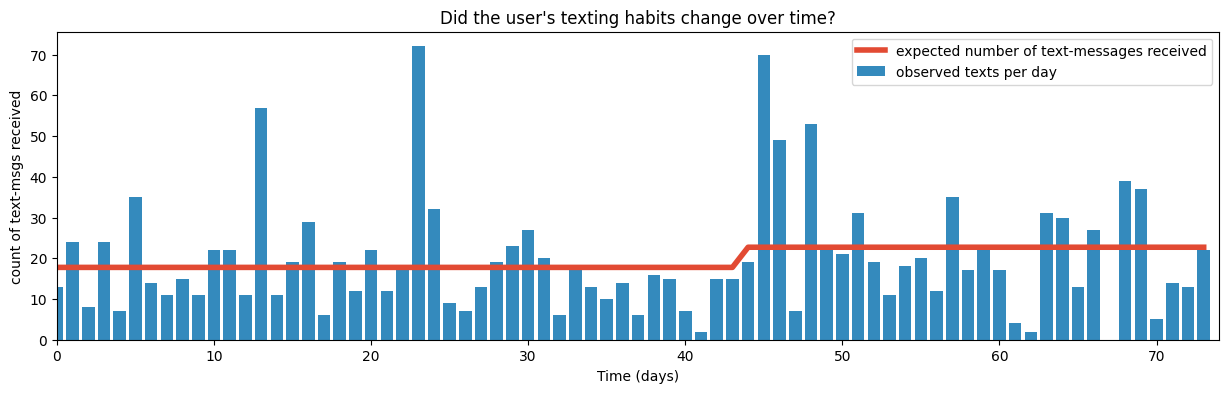

In [ ]:
# @title
lambda1_mean = float(idata3.posterior.lambda_1.mean())
lambda2_mean = float(idata3.posterior.lambda_2.mean())
tau_mean     = int(idata3.posterior.tau.mean())

regime1 = np.repeat(lambda1_mean, tau_mean)
regime2 = np.repeat(lambda2_mean, n_count_data-tau_mean)
expected_texts_per_day = np.concatenate((regime1, regime2))

fig, ax = plt.subplots(figsize=(15, 4))
ax.set_title("Did the user's texting habits change over time?")
ax.set_xlabel("Time (days)")
ax.set_ylabel("count of text-msgs received")
ax.set_xlim(0, n_count_data)
ax.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
ax.bar(np.arange(n_count_data), count_data, color="#348ABD",
         label="observed texts per day")
ax.legend(loc="upper right");

And, since we can generate samples from the posterior, we are able to answer other questions:

 + What is the posterior $p(\lambda_1 | \mathcal{D})$:

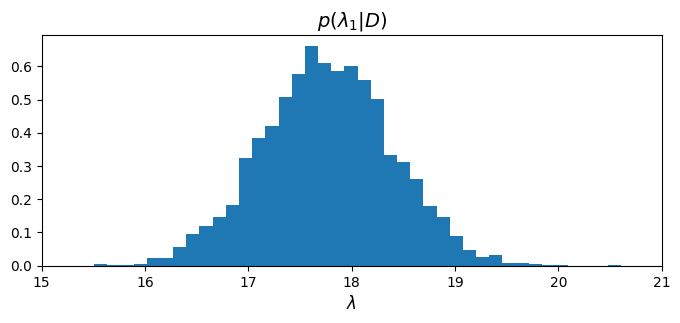

In [ ]:
# @title
lambda_1_samples = idata3.posterior['lambda_1'].loc[0]

show_hist([lambda_1_samples],
          figsize  = (8,3),
          title    = r'$p(\lambda_1 | D)$',
          var_name = r'$\lambda$',
          xlim     = (15,21))

+ What is the expected percentage increase in text-message rates?

In [ ]:
lambda_2_samples = idata3.posterior['lambda_2'].loc[0]

# use Poisson to draw number of messages per regime
msgs_regime1 = np.random.poisson(lambda_1_samples)
msgs_regime2 = np.random.poisson(lambda_2_samples)

perc = float((msgs_regime2/msgs_regime1).mean())-1
print(f'{perc:.1%}')

37.3%


+ What is the probability that the number of messages in regime 2 is higher than in regime 1?

In [ ]:
prob = sum(msgs_regime2 > msgs_regime1) / len(msgs_regime1)
print(f'{prob:.1%}')

75.7%


## References

+ Cam Davidson-Pilon - [Probabilistic Programming and
Bayesian Methods for Hackers](https://nbviewer.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Prologue/Prologue.ipynb) (2015)

+ Richard McElreath - [Statistical Rethinking](https://www.youtube.com/playlist?list=PLDcUM9US4XdPz-KxHM4XHt7uUVGWWVSus) (2023), a great semester course

Other References:

+ Allen Downey - [Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC/index.html) (2021)

+ Jake VanderPlas - [Frequentism and Bayesianism: A Practical Introduction](https://jakevdp.github.io/tag/bayesianism.html) (2014), a 5-part series of posts

+ Osvaldo Martin - [Bayesian Modeling and Computation in Python](https://bayesiancomputationbook.com/welcome.html) (2021)